In [1]:
import matplotlib.pyplot as plt
from scipy.stats import lognorm, chisquare, expon, gamma, norm
import numpy as np

In [2]:
class Times:
    def __init__(self, t_enter, t_start, t_leave):
        self.enter = t_enter
        self.start = t_start
        self.leave = t_leave
        
    def __str__(self):
        return "Enter at " + self.enter + "\tStart at " 
                + self.start + "\tLeave at " + self.leave
        
        
class Office:
    def __init__(self):
        self.clients = []
        self.count = 0
            
    def __str__(self):
        line = str(self.count) + " operators; "
        line += "clients are:\n"
        for client in self.clients:
            line += client.__str__()
        return line

    
def read_office_from_file(file_name):
    office = Office()
    file = open(file_name, "r")
    office.count = int(file.readline().split(' ')[-1])
    file.readline()
    for line in file:
        times = line.split("\t")
        office.clients.append(Times(int(times[0]), 
                                    int(times[1]), 
                                    int(times[2])))
    return office

In [3]:
files = ["26/office_" + str(i) for i in range(0, 5)]    
offices = [read_office_from_file(file_name) for file_name in files]
print("Всего %d отделений" % len(offices))    

Всего 5 отделений


In [4]:
def show_times_in_office(office):
    plt.figure(figsize=(20,50))
    for i in range(0, len(office.clients)):
        plt.plot([office.clients[i].enter, 
                  office.clients[i].start], 
                 [i + 1, i + 1], color="red")
        plt.plot([office.clients[i].start, 
                  office.clients[i].leave], 
                 [i + 1, i + 1], color="green")
    plt.ylim(0, len(office.clients))
    plt.show()

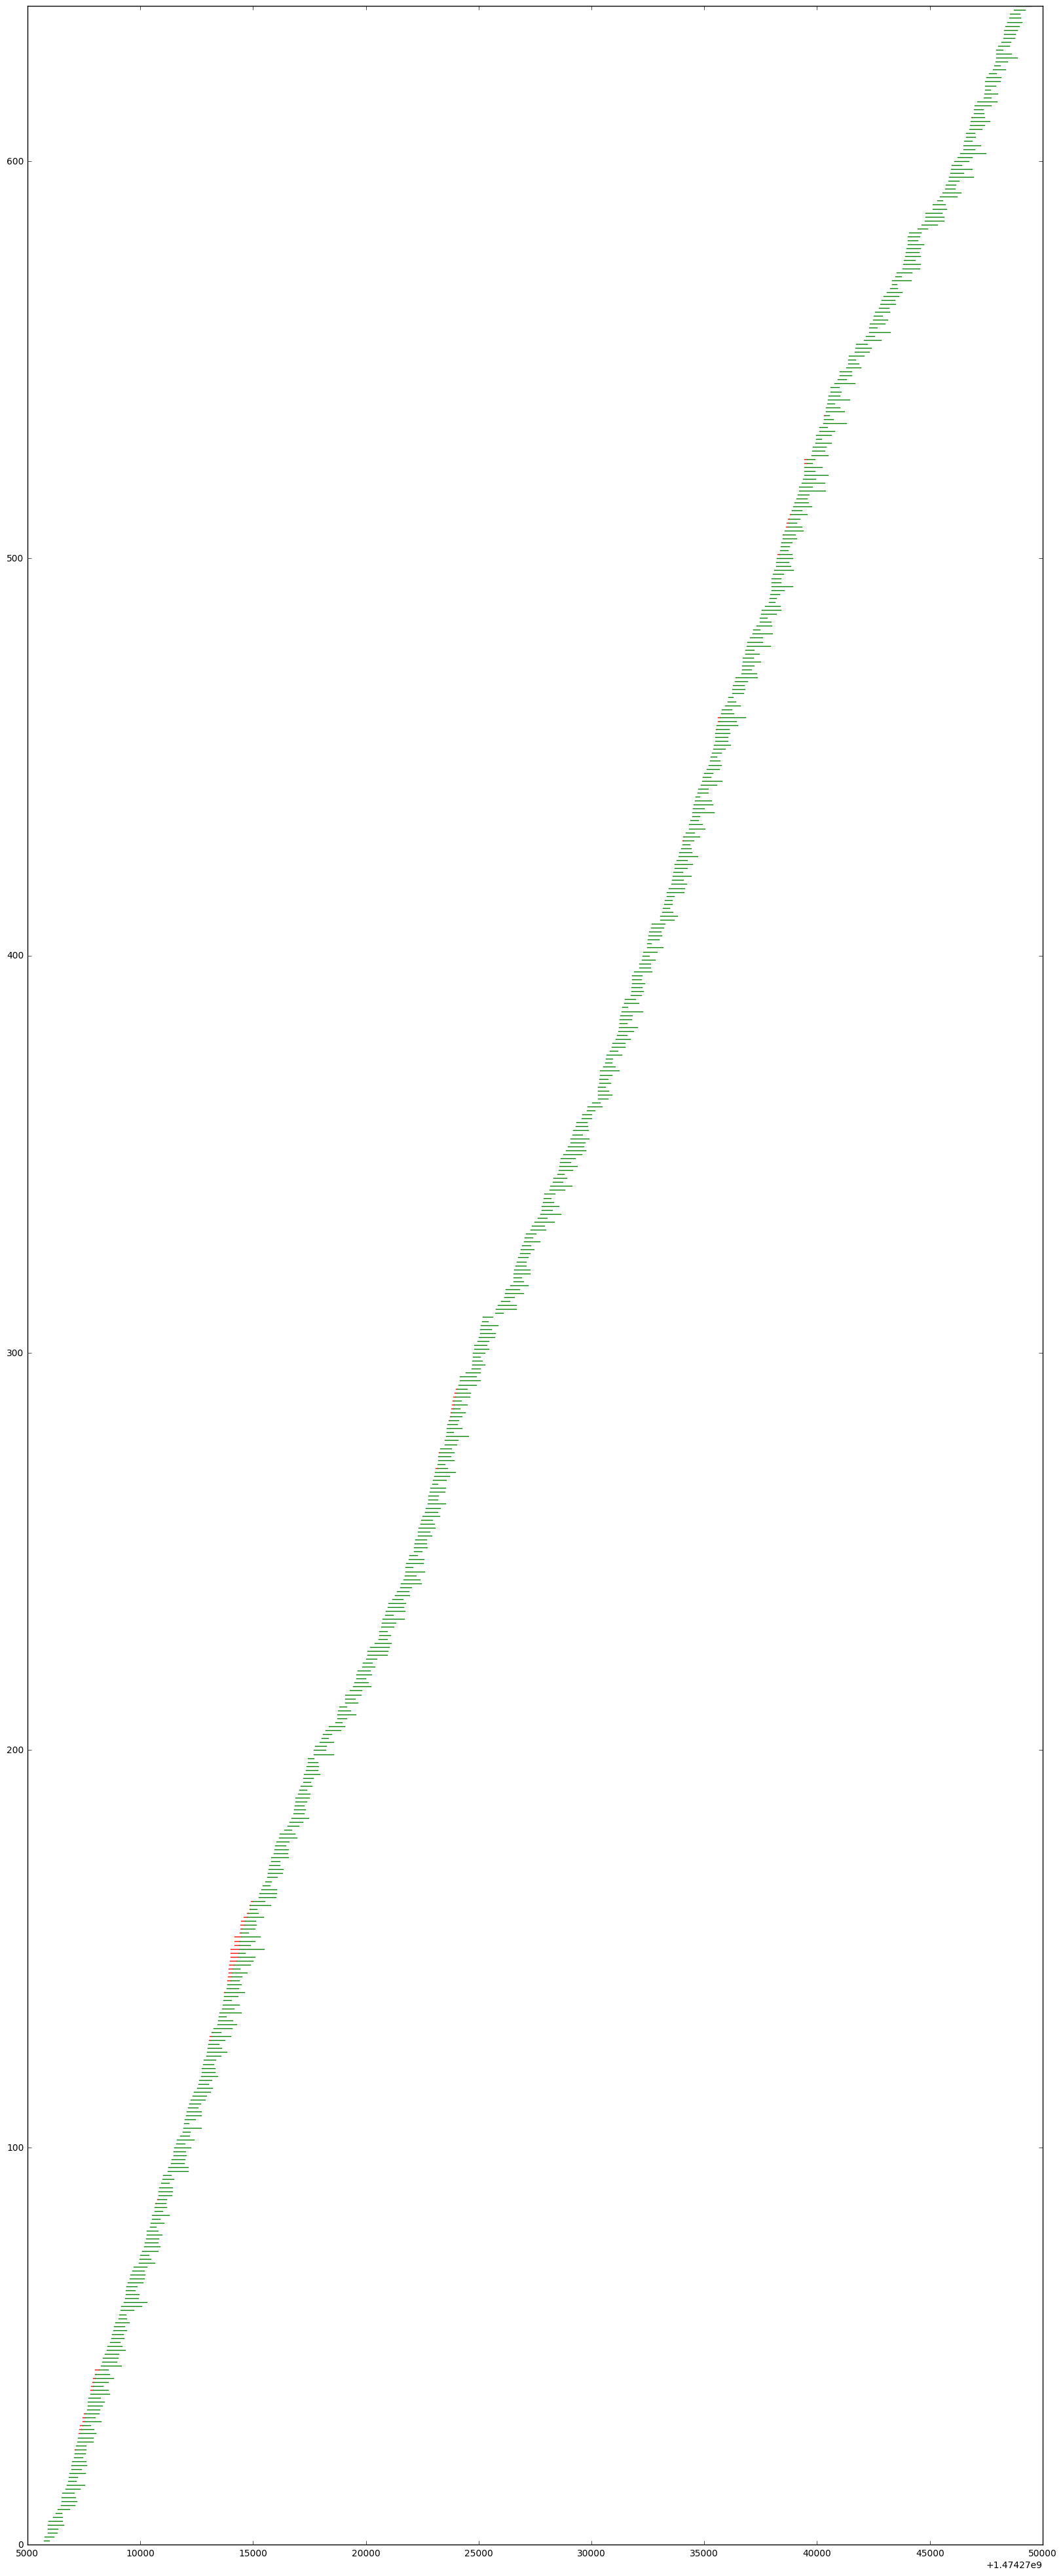

In [5]:
show_times_in_office(offices[0])

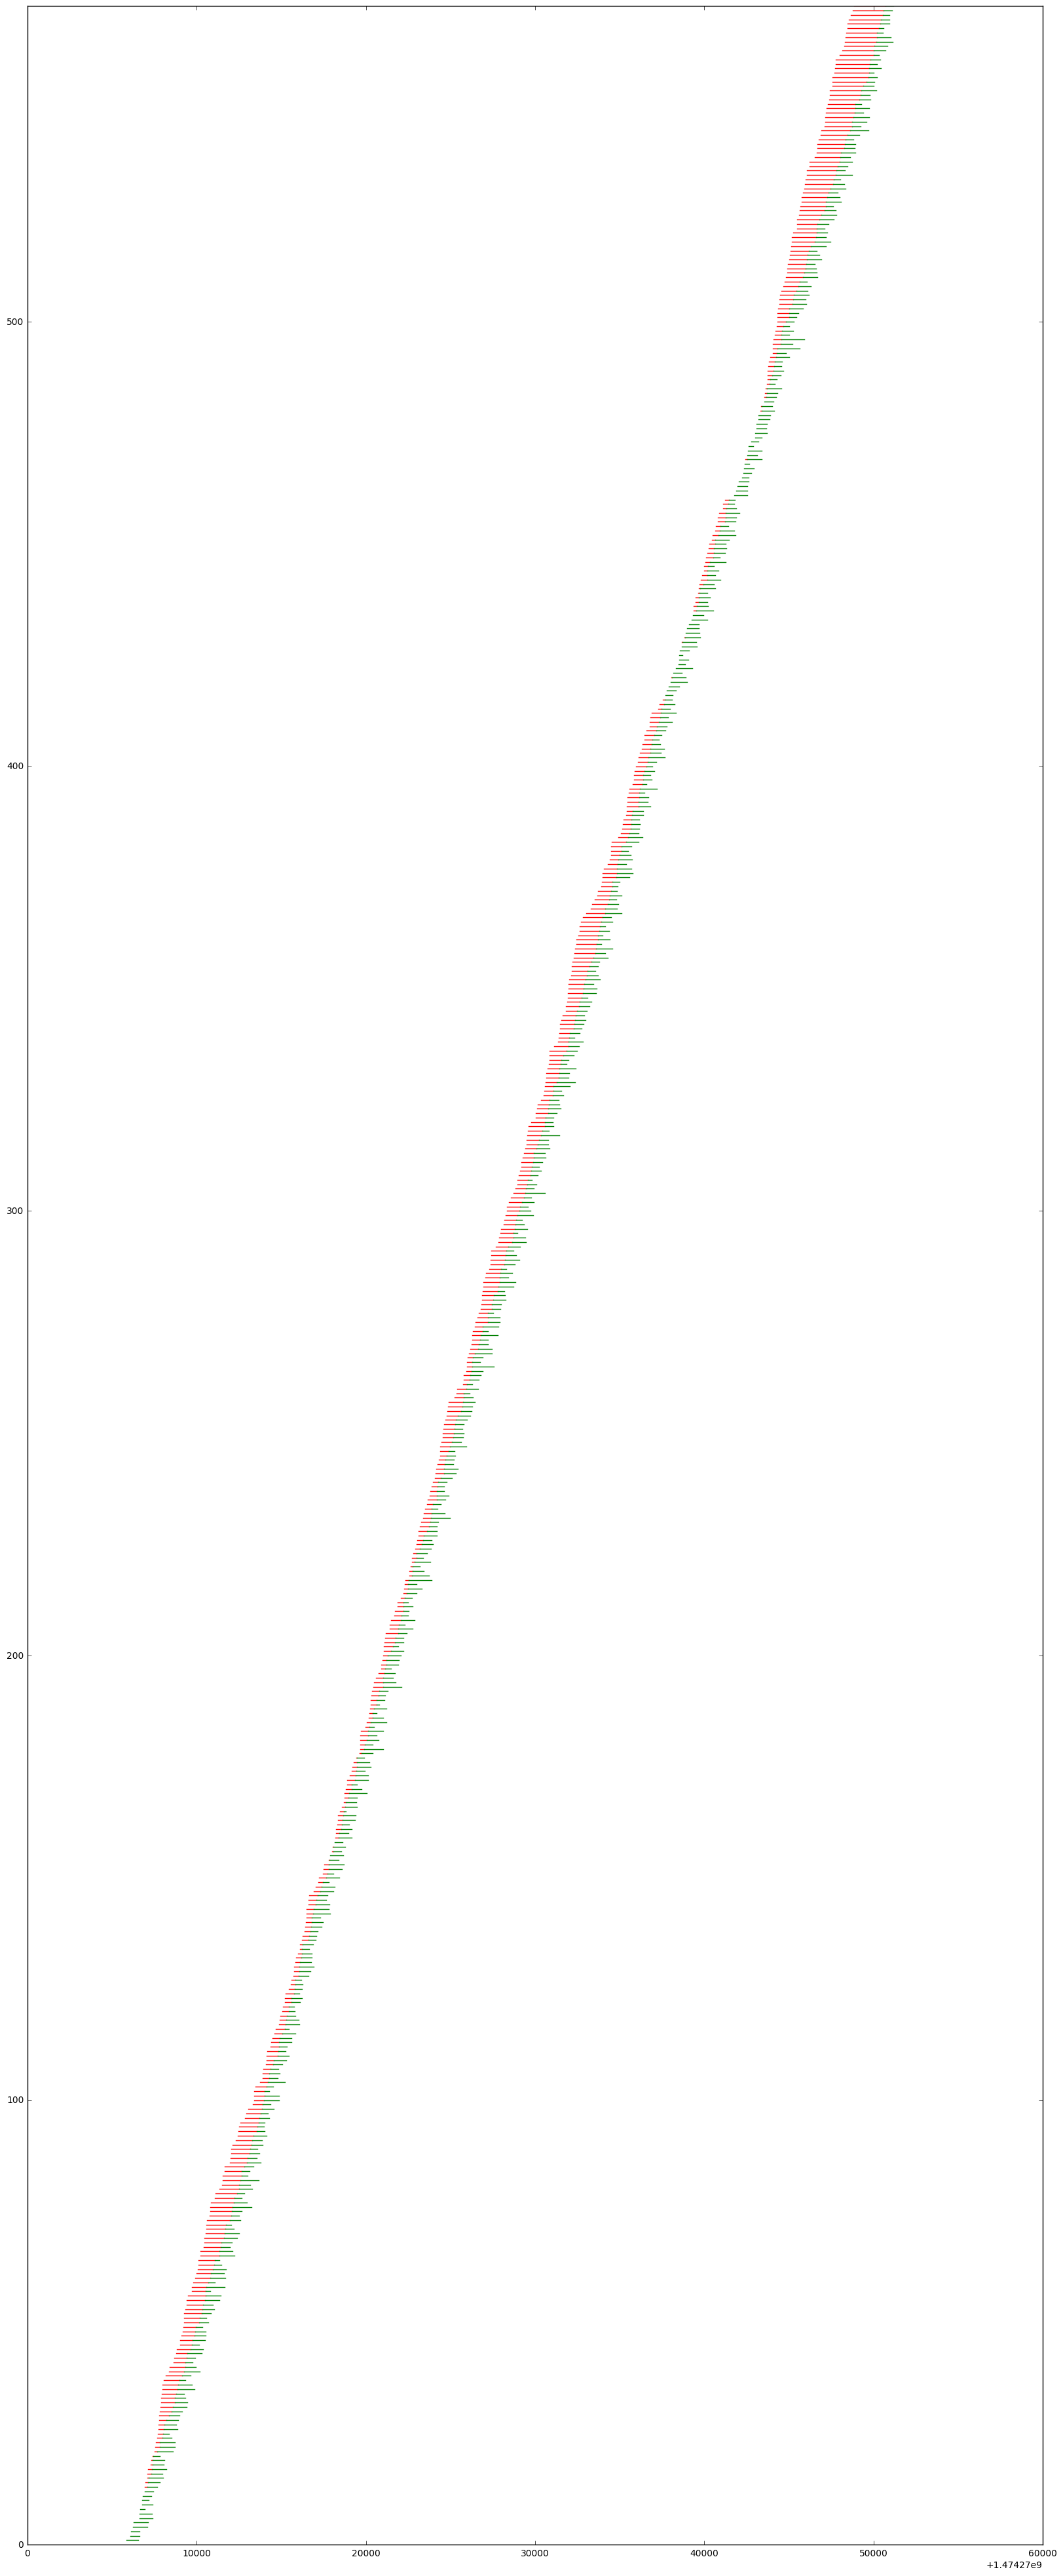

In [6]:
show_times_in_office(offices[1])

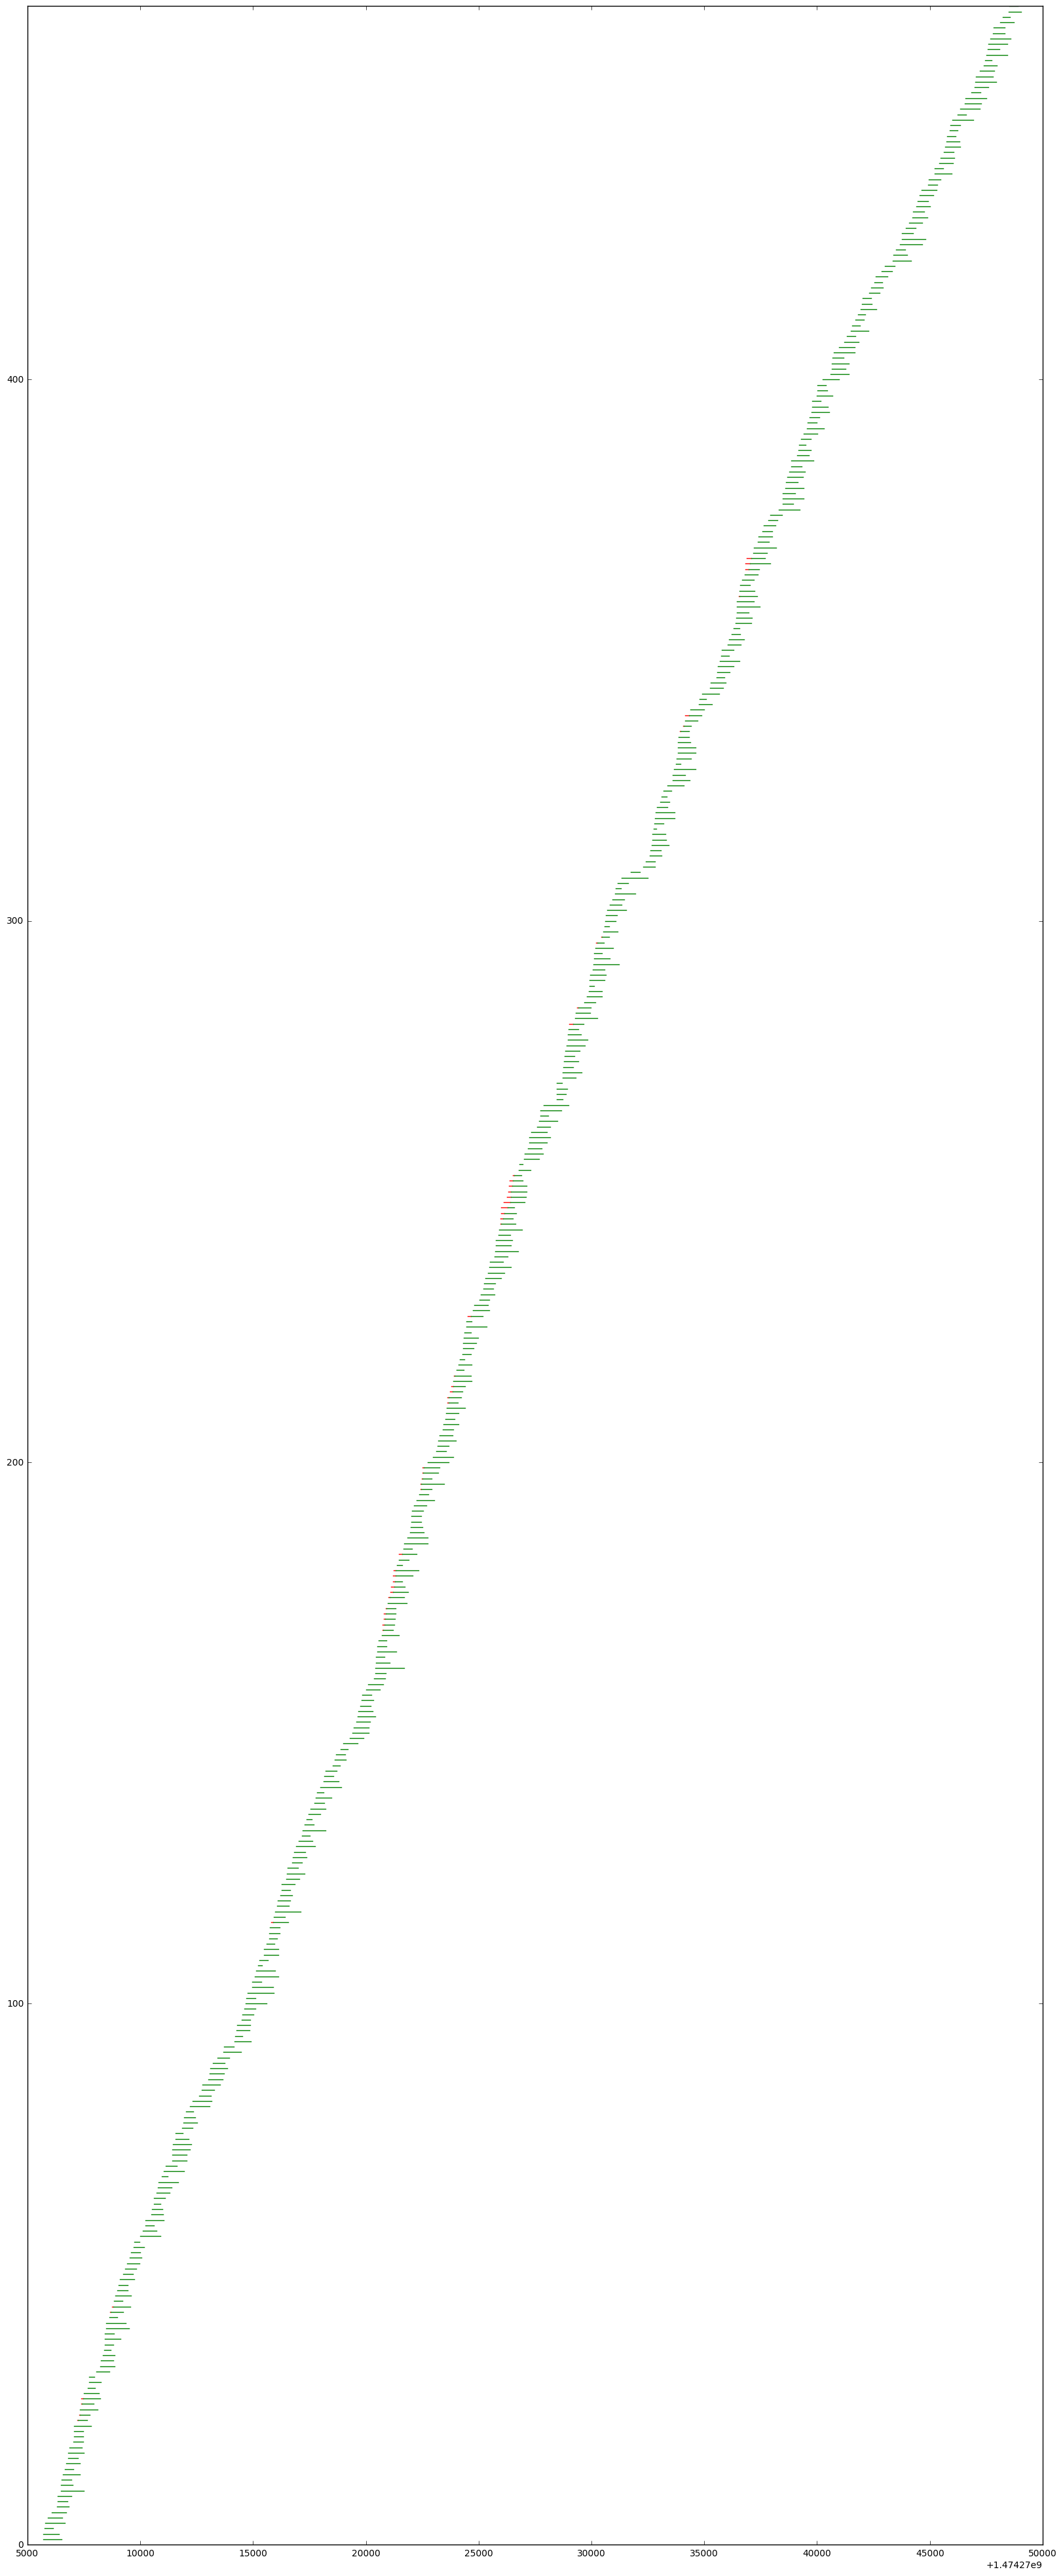

In [7]:
show_times_in_office(offices[2])

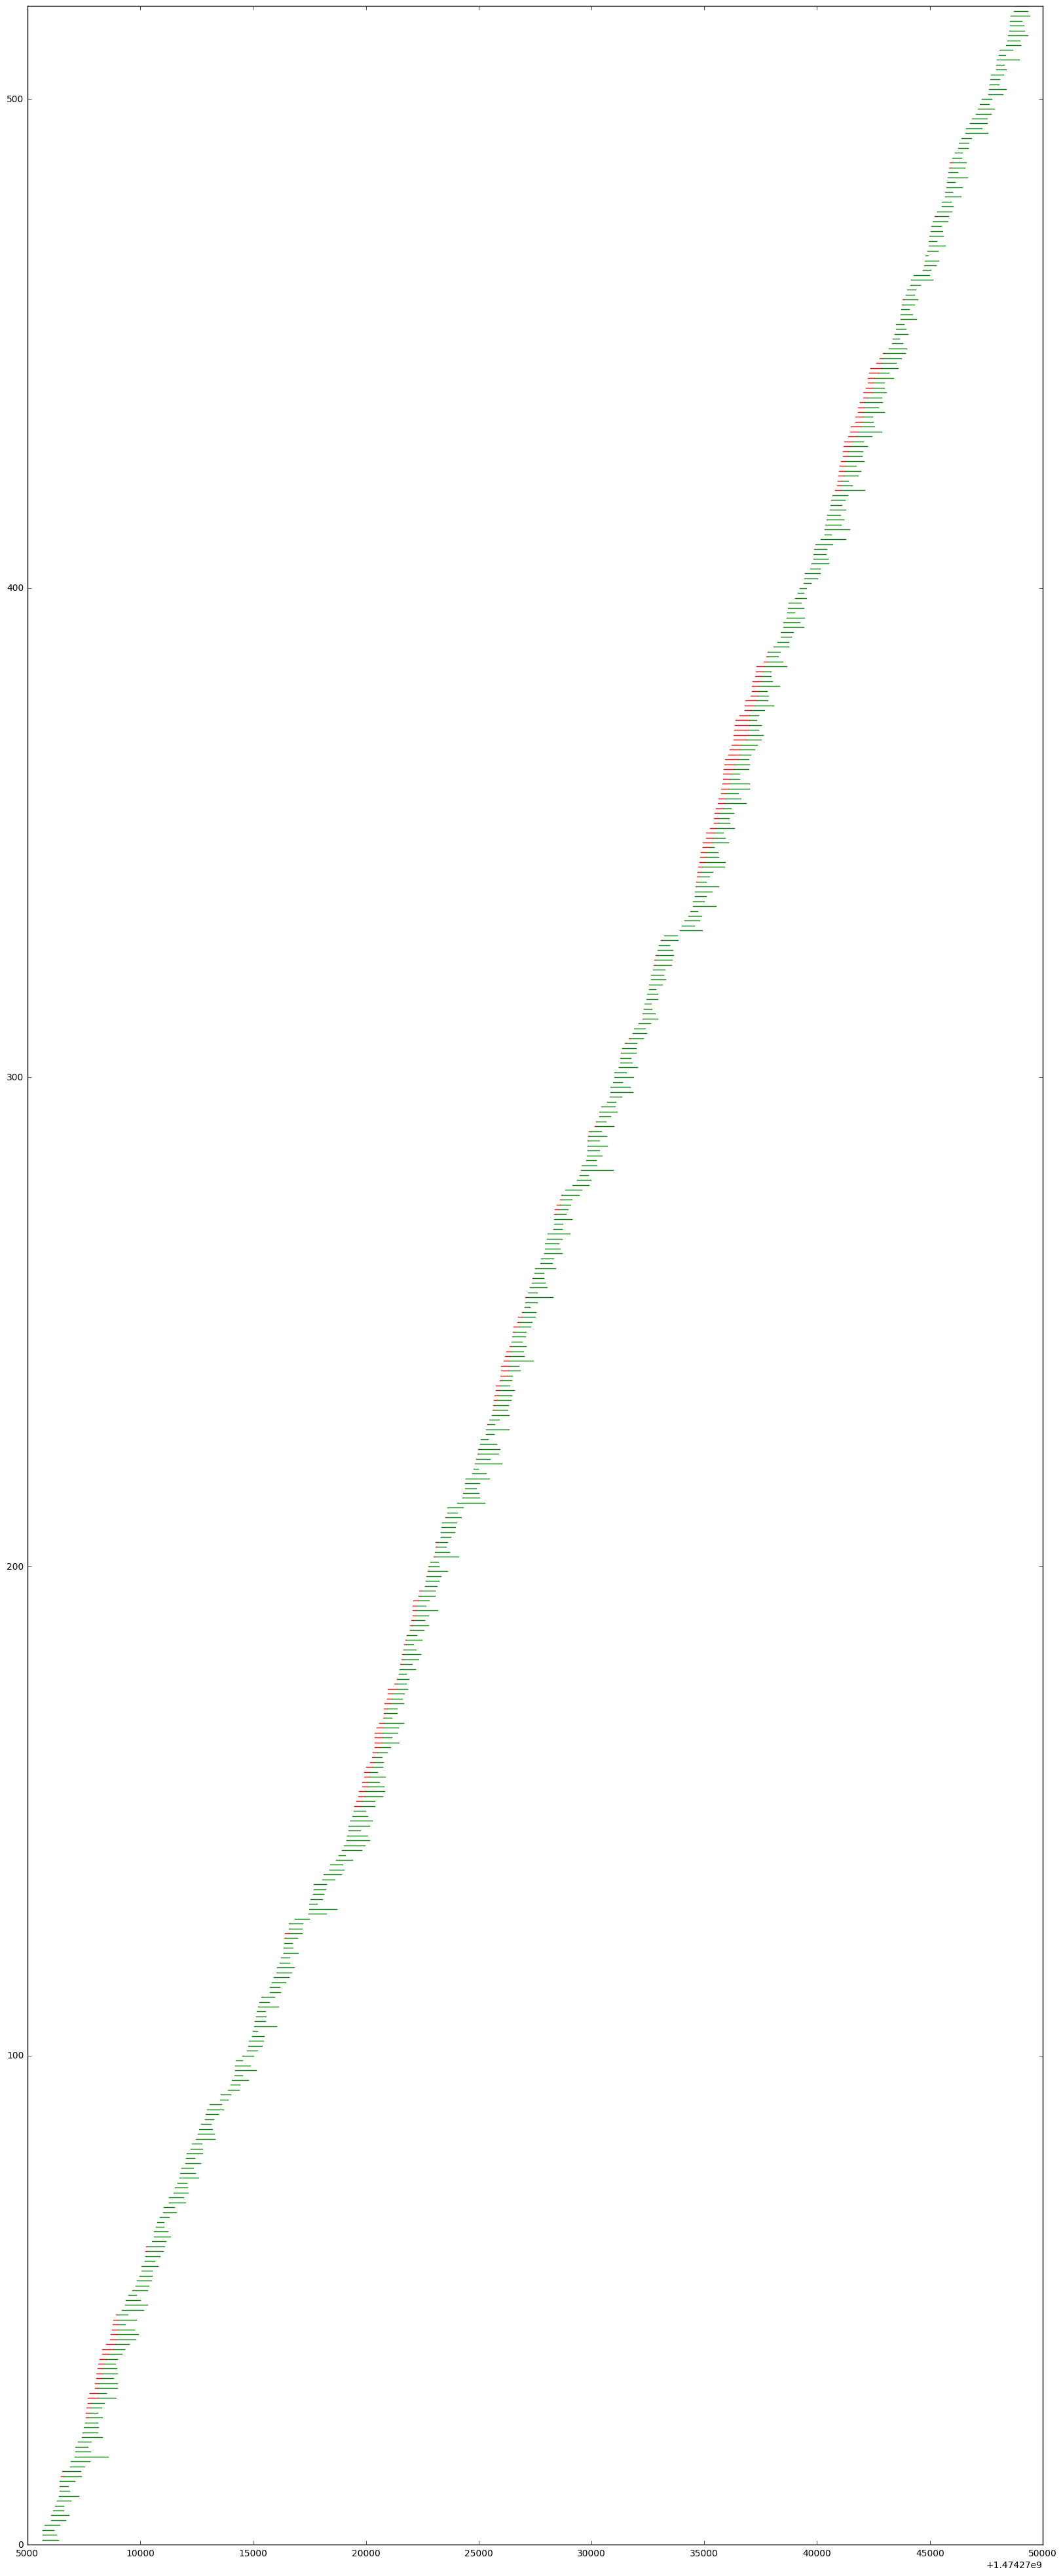

In [8]:
show_times_in_office(offices[3])

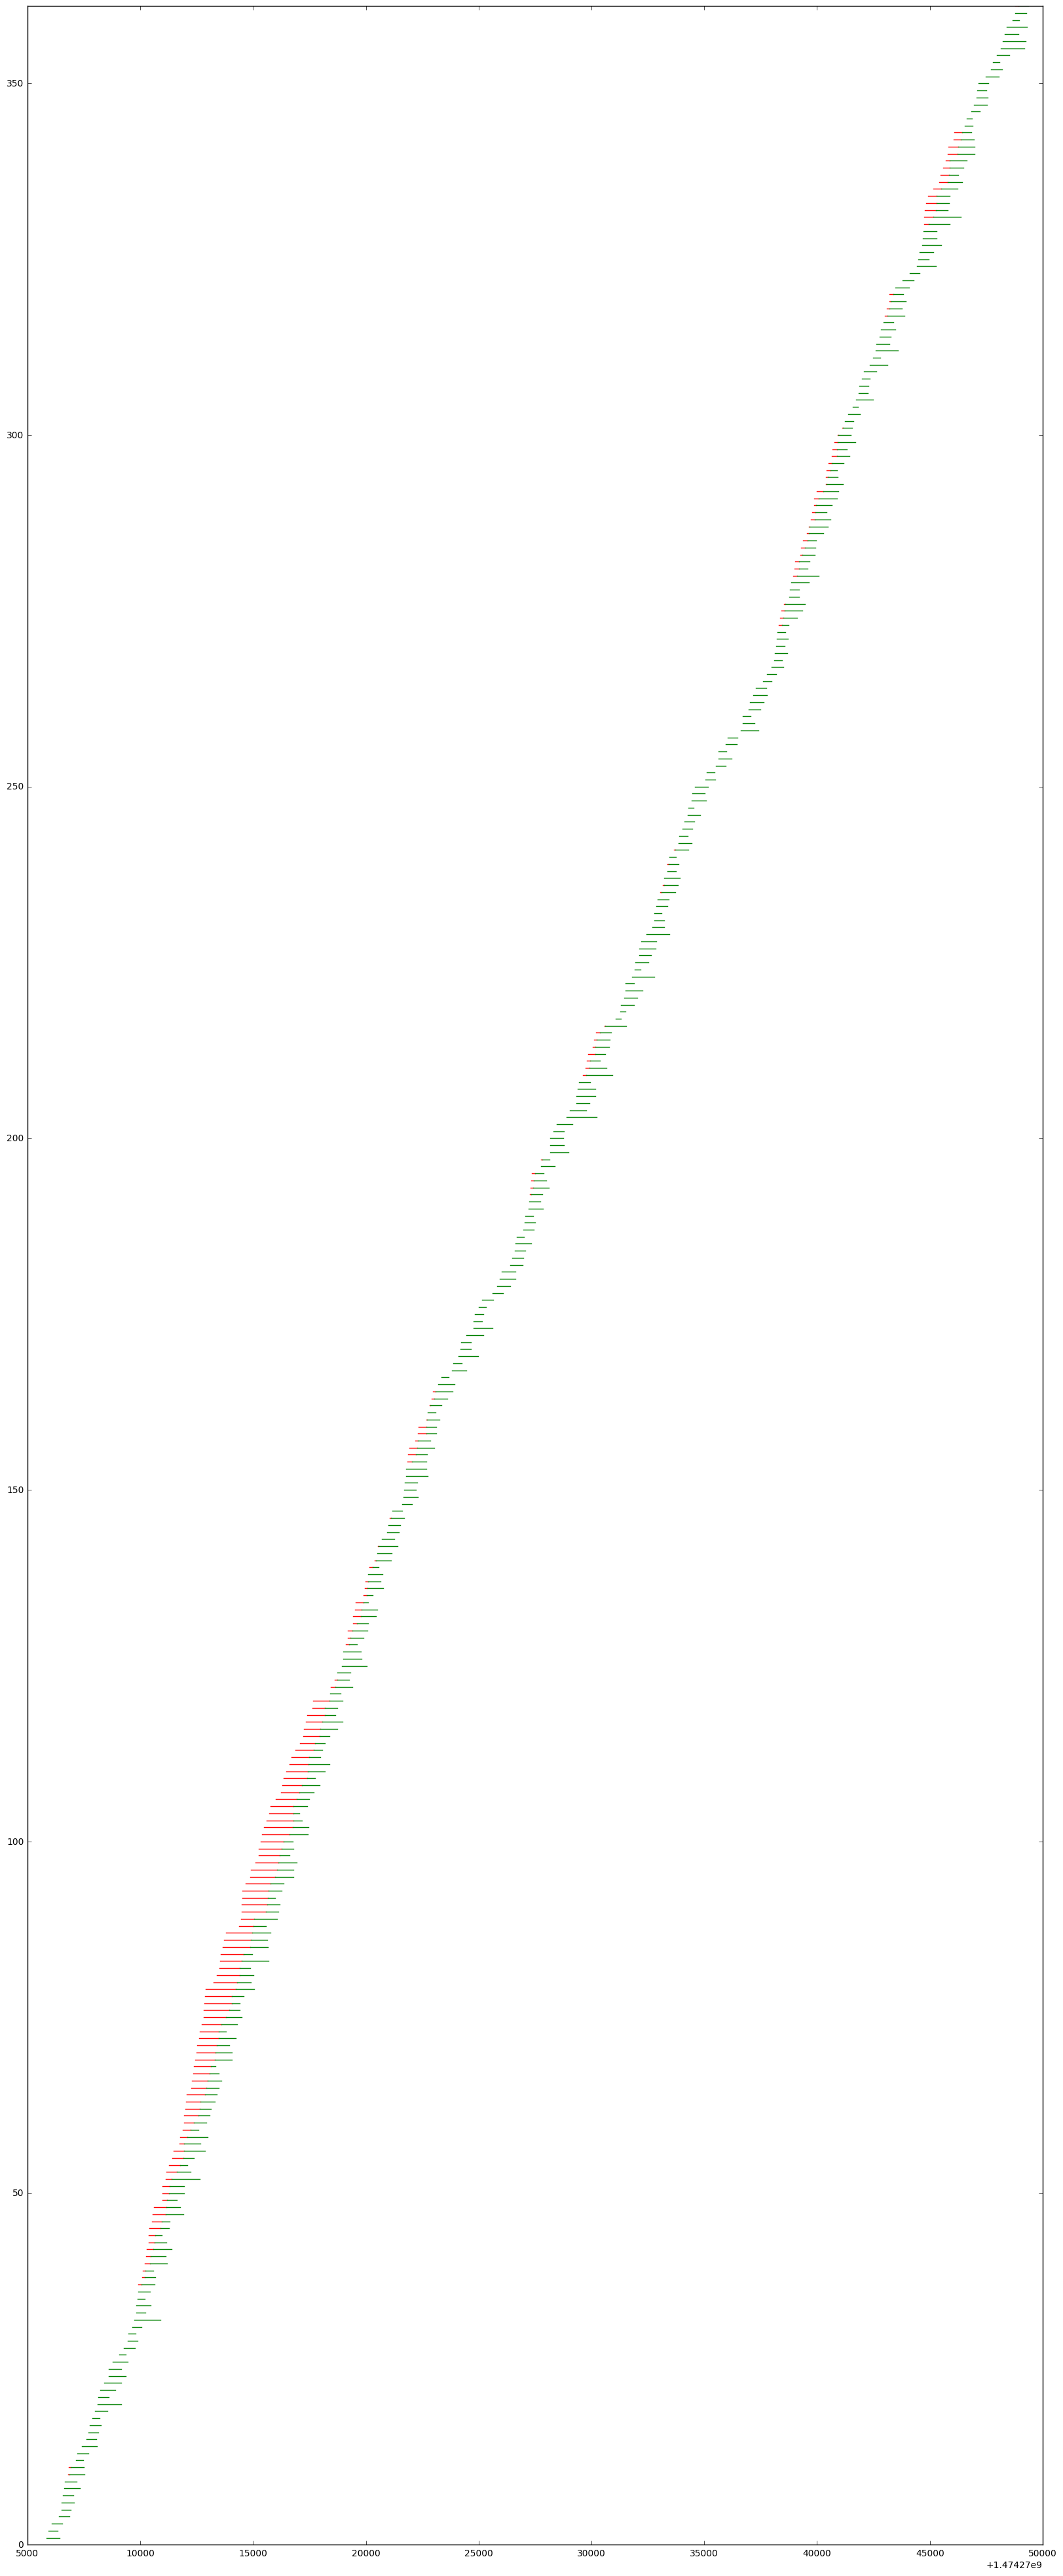

In [9]:
show_times_in_office(offices[4])

Так как по условию считаем, что время между приходом одного клиента и приходом следующего распределено экспоненциально с неким параметром $\lambda$, тогда $N_t=sup\{n:S_n\le t\}$ процесс восстановления построенный по этим случайным величинам удовлетворяет теореме о явной конструкции пуассоновскгого процесса, значит $N_t$ - пуассоновский процесс.

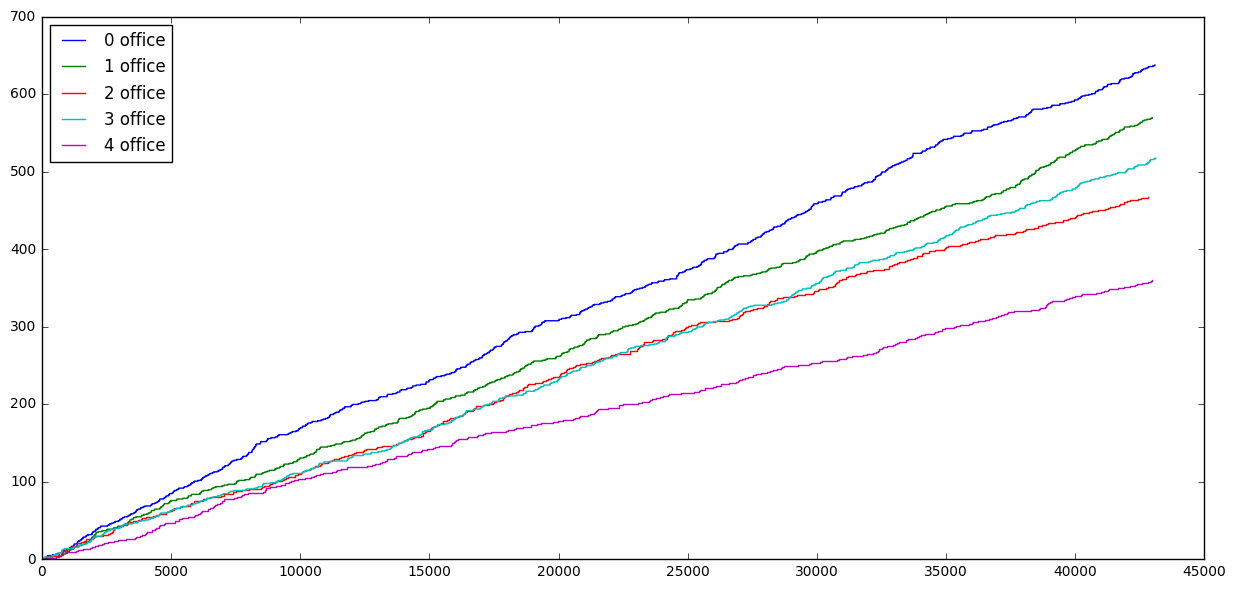

In [10]:
pois = [[client.enter - office.clients[0].enter for client in office.clients] 
        for office in offices]
plt.figure(figsize=(15, 7))
for i in range(0, len(pois)):
    y = [y for y in range(0, len(pois[i])) for _ in [0, 1]]
    x = [x for x in pois[i] for _ in [0, 1]]
    x = x[1:len(x):1]
    y = y[:-1]
    plt.plot(x, y, label="%d office" % i)
plt.legend(loc='upper left')
plt.show()

Оценим параметр $\lambda$ методом максимального правдоподобия. $\lambda = \frac{1}{\overline X}$

In [11]:
# оценим параметр lambda экспоненциального распределения
exp_lambdas = [1. / np.mean([office.clients[i].enter - 
                             office.clients[i - 1].enter 
                             for i in range(1, len(office.clients))]) 
               for office in offices]

for i in range(0, len(offices)):
    print("Для отделения %d lambda=%f" % (i, exp_lambdas[i]))

Для отделения 0 lambda=0.014809
Для отделения 1 lambda=0.013262
Для отделения 2 lambda=0.010928
Для отделения 3 lambda=0.012015
Для отделения 4 lambda=0.008380


Теперь необходимо определить, к какому прараметрическому семейству принадлежит случайная величина - время обслуживания. Построим гистограмму, чтобы делать предположения о распределении. 

Первая идея - логнормальное распределение. Рассчитаем оценки его параметров: 
<ul>
    <li>$ \mu=\overline {ln (X)} $</li>
    <li>$ \sigma^2=\overline {(ln (X) - \mu)^2} $</li>
</ul>

In [12]:
# Посчитаем оценку параметров логнормального распределения
def lognorm_estimation(sample):
    mu = np.mean(np.log(sample))
    sigma = (np.mean((np.log(sample) - mu) ** 2)) ** 0.5
    return mu, sigma

mu=6.282821, sigma=0.338568


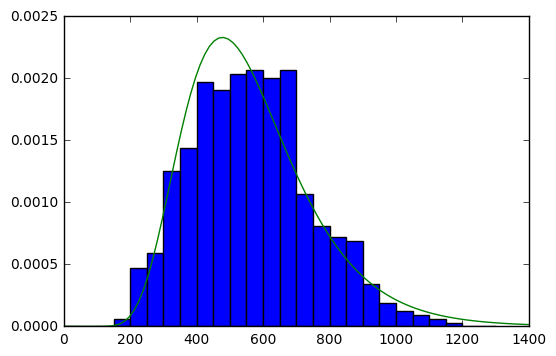

mu=6.366744, sigma=0.351165


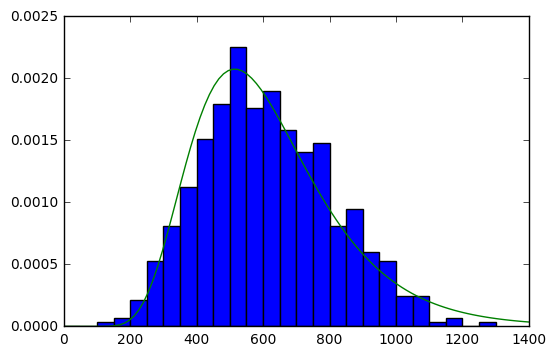

mu=6.300732, sigma=0.366222


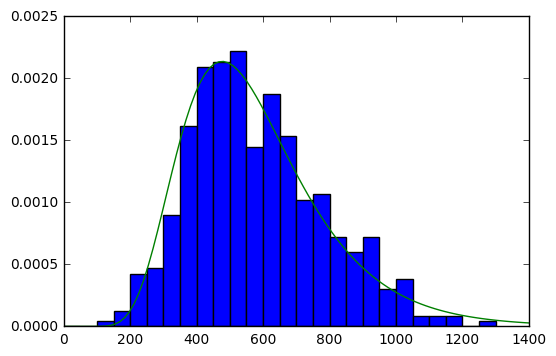

mu=6.343162, sigma=0.331446


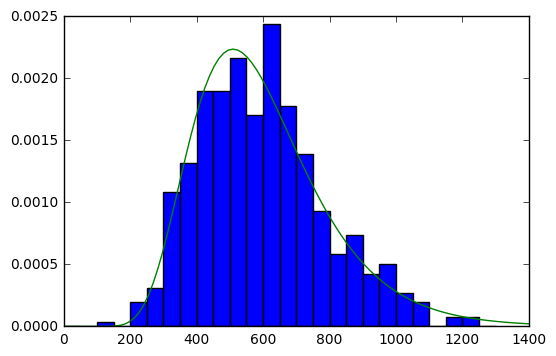

mu=6.289444, sigma=0.340897


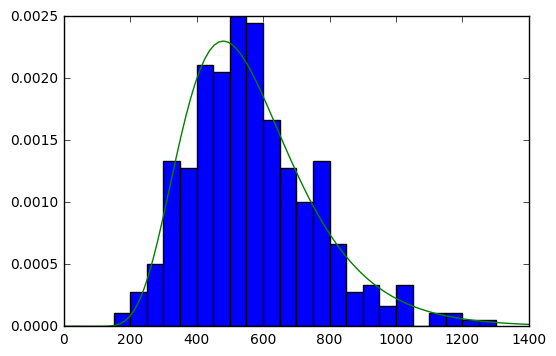

In [15]:
processing = [[client.leave - client.start 
               for client in office.clients] 
              for office in offices]
lingrid = np.linspace(0, 1400, num=100)
grid = [t * 50 for t in range(0, 27)]
for deltas in processing:
    plt.hist(deltas, bins=grid, normed=True)
    mu, sigma = lognorm_estimation(deltas)
    print("mu=%f, sigma=%f" % (mu, sigma))
    y = np.array(lognorm.pdf(lingrid, s=sigma, scale=np.exp(mu)))
    plt.plot(lingrid, y)
    plt.subplots_adjust()
    plt.show()

In [14]:
grid = [0, 300, 400, 500, 650, 800, 1400]
for data in processing:
    mu, sigma = lognorm_estimation(data)
    print("mu=%f, sigma=%f" % (mu, sigma))
    observed = []
    expected_lognorm = []

    for i in range(0, len(grid) - 1):
        observed.append(len([value for value in data 
                             if value >= grid[i] 
                             and value < grid[i + 1]]))
        expected_lognorm.append(lognorm.cdf(grid[i + 1], 
                                            s=sigma, 
                                            scale=np.exp(mu)) - 
                         lognorm.cdf(grid[i], 
                                     s=sigma, 
                                     scale=np.exp(mu)))

    observed = np.array(observed)
    expected_lognorm = np.array(expected_lognorm) * len(data)
    print(chisquare(observed, expected_lognorm).pvalue)

mu=6.282821, sigma=0.338568
0.0648462490185
mu=6.366744, sigma=0.351165
0.117939560626
mu=6.300732, sigma=0.366222
0.80046462208
mu=6.343162, sigma=0.331446
0.939012026076
mu=6.289444, sigma=0.340897
0.649593243349


В целом можно принять гипотезу о том, что время работы с клиентом имеет логнормальное распределение.

In [23]:
for i in range(0, len(offices)):
    mu, sigma = lognorm_estimation(processing[i])
    print("Среднее время обслуживания клиента в офисе " +
          "%d составляет %d единиц времени (реально %d)" 
          % (i, lognorm.mean(s=sigma, scale=np.exp(mu)), 
             np.mean(processing[i])))

Среднее время обслуживания клиента в офисе 0 составляет 566 единиц времени (реально 565)
Среднее время обслуживания клиента в офисе 1 составляет 619 единиц времени (реально 617)
Среднее время обслуживания клиента в офисе 2 составляет 582 единиц времени (реально 580)
Среднее время обслуживания клиента в офисе 3 составляет 600 единиц времени (реально 599)
Среднее время обслуживания клиента в офисе 4 составляет 571 единиц времени (реально 570)
